### Imports

In [54]:
# Stanadard libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Functions from other scripts
from DataCollectionScript import load_SQL_Data, get_puuid, get_match_hist, get_match_data_from_id, process_match_json, convert_df_ids
from GradientBoostingModelScript import load_model, build_gb_preprocessor, remove_null, split_features

# Machine Learning Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Loading ENV
from dotenv import load_dotenv
import os

# Loading dotenv file for code
load_dotenv()

# Riot Games API Key
API_Key = os.environ.get('riot_api_key')

### Gathering Player Games

In [67]:
# Goal: gather and process 20 games from a player of choice 

# player: Krelekrele
# tag: #NA1
# Oldest Match too Look for: NA1_5221759288

#get_puuid(PlayerName='Krelekrele',PlayerTag='NA1')

# puuid: Kc4mIgXETqVivYSnMhx1iLh2sN5sz_plAf_fYBkVhU9mIZaaGNFx26DDpsCu5j40amKrGmQltmJ-gQ

puuid_test = 'Kc4mIgXETqVivYSnMhx1iLh2sN5sz_plAf_fYBkVhU9mIZaaGNFx26DDpsCu5j40amKrGmQltmJ-gQ'

# for debugging
def debug_print(message, debug=True):
    """Prints message only if debug mode is enabled."""
    if debug:
        print(message)

# finding estimate for how far back to start search

def find_patch(puuid, start, min_oldest_id, debug = False):

    """" 
    Can just copy and past the string into the function for the oldest match id 
    puuid is just the players puuid you want
    start will calculate where you need to start
    
    """
    
    numeric_id_list = []

    min_oldest_id = int(min_oldest_id.replace('NA1_', ''))

    # Fetch match history initially
    match_ids = get_match_hist(puuid=puuid, start=start, count=100)

    flag = False

    while flag == False:
        # Process each match ID
        for id in match_ids:
            # Strip the "NA1_" part and convert to an integer
            numeric_id = int(id.replace('NA1_', ''))
            numeric_id_list.append(numeric_id)

        # Check if any of the numeric IDs are greater than the min_oldest_id value
        for num_id in numeric_id_list:
            if num_id > min_oldest_id:
                debug_print(f'NA1_{num_id} is not old enough trying next....', debug)
                start = start + 1
            else:
                debug_print(f'NA1_{num_id} is older than minimum, Starting ID found', debug)
                flag = True
                break

        if flag == False:
            # Increase the 'start' variable by 50 and get new match history
            numeric_id_list = []  # Reset the numeric ID list for the next batch
            match_ids = get_match_hist(puuid=puuid, start=start)  # Re-fetch match history with updated 'start'
            debug_print('Generating New Match History....', debug)
        else:
            debug_print(f'Starting point is: {start}', debug)
            break

    debug_print('Finished Search', debug)
    return start


# getting player data
puuid = get_puuid(PlayerName='Krelekrele', PlayerTag='NA1')[0]

matchIds = get_match_hist(puuid=puuid, start=135, count=30)

dataframes = []

for id in matchIds:
    game = get_match_data_from_id(id)[0]
    matchDF = process_match_json(game, puuid=puuid)

    # Ensure matchId and puuid exist before creating uuid
    if 'matchId' in matchDF.columns and 'puuid' in matchDF.columns:
        matchDF = convert_df_ids(matchDF)
        matchDF['uuid'] = matchDF['matchId'] + '_' + matchDF['puuid']
        matchDF = matchDF.set_index('uuid')  # Assign back to matchDF
    
    dataframes.append(matchDF)

# Concatenate all match DataFrames **after** looping
df = pd.concat(dataframes) if dataframes else pd.DataFrame()


PUUID Function Call #11 - URL: https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/Krelekrele/NA1, Response Code: 200
Match ID: NA1_5209163230, Response Code: 200
Match ID: NA1_5209142980, Response Code: 200
Match ID: NA1_5209102795, Response Code: 200
Match ID: NA1_5209078008, Response Code: 200
Match ID: NA1_5208860116, Response Code: 200
Match ID: NA1_5208839293, Response Code: 200
Match ID: NA1_5208823807, Response Code: 200
Match ID: NA1_5208794532, Response Code: 200
Match ID: NA1_5208516538, Response Code: 200
Match ID: NA1_5208488066, Response Code: 200
Match ID: NA1_5208452586, Response Code: 200
Match ID: NA1_5208424497, Response Code: 200
Match ID: NA1_5208389582, Response Code: 200
Match ID: NA1_5208050014, Response Code: 200
Match ID: NA1_5208037740, Response Code: 200
Match ID: NA1_5207717274, Response Code: 200
Match ID: NA1_5207059029, Response Code: 200
Match ID: NA1_5206727100, Response Code: 200
Match ID: NA1_5206687138, Response Code: 200
Match ID

### Preprocessing Player Games

In [191]:
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Step 1: Load your pre-trained model
model, _, _, = load_model()

# Step 3: Preprocess the DataFrame (apply transformations)
df_pre = df.copy()
df_pre.reset_index(inplace=True)

# Remove nulls (if any)
df_pre = remove_null(df_pre)



for col in cat_cols:
    df_pre[col] = df_pre[col] = df_pre[col].astype(str)


bool_cols = df_pre.select_dtypes(include='bool').columns

for col in bool_cols:
    df_pre[col] = df_pre[col].astype(int)

# Step 2: Define your preprocessor (same as used during training)
num_cols = df_pre.select_dtypes(include='number').columns
cat_cols = df_pre.select_dtypes(include='object').columns

gb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X = df_pre.drop('win',axis=1)
y = df_pre['win']


# Step 4: Make predictions using the model
predictions = model.predict(X)

# Step 5: Display predictions (for example, the first 5 predictions)

predict_df = pd.DataFrame({

    'Prediction' : predictions,
    'Actual' : df_pre['win']

})

predict_df

# 100% accuracy yay 

predict_df.value_counts()

# Total wins 16
# Total loss 14

Prediction  Actual
True        1         16
False       0         14
Name: count, dtype: int64

### Analyzing Player Games with ML Model Important Factors

     damageDealtToTurrets  turretsLost  longestTimeSpentLiving  teamKills  \
win                                                                         
0             2313.357143     8.857143              840.428571  23.214286   
1             3044.375000     2.625000              488.125000  32.250000   

     inhibitorsLost  inhibitorTakedowns  
win                                      
0          1.714286              0.0000  
1          0.062500              0.4375  


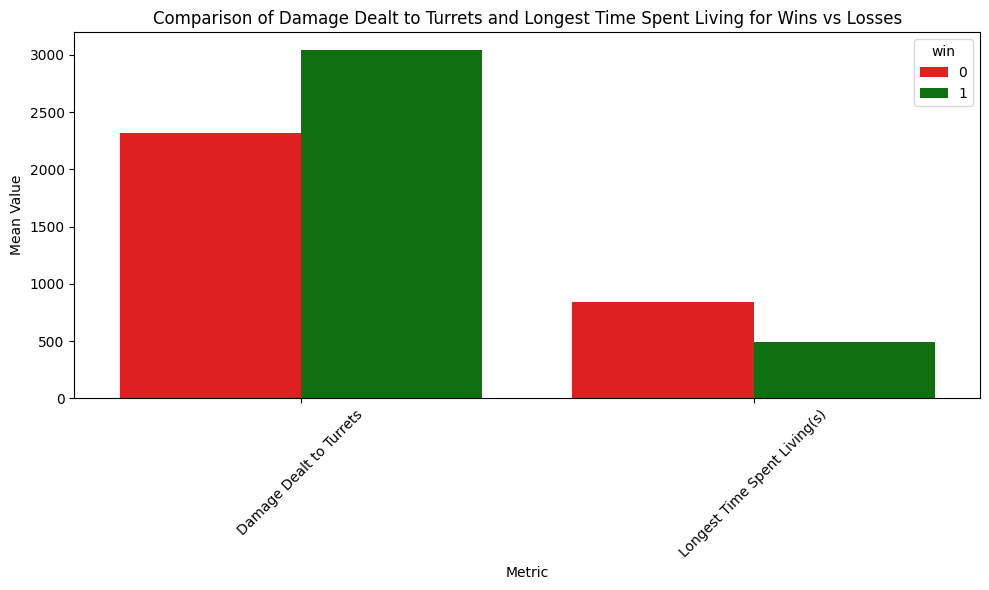

In [141]:
damage2Turrets = df_pre.groupby('win')['damageDealtToTurrets'].mean()
towersLost = df_pre.groupby('win')['turretsLost'].mean()
longestTimeAlive = df_pre.groupby('win')['longestTimeSpentLiving'].mean()
teamKills = df_pre.groupby('win')['teamKills'].mean()
inhibitorsLost = df_pre.groupby('win')['inhibitorsLost'].mean()
inhibitorTakedowns = df_pre.groupby('win')['inhibitorTakedowns'].mean()

# Combine all these series into a single DataFrame
comparison_df_whole = pd.DataFrame({
    'damageDealtToTurrets': damage2Turrets,
    'turretsLost': towersLost,
    'longestTimeSpentLiving': longestTimeAlive,
    'teamKills': teamKills,
    'inhibitorsLost': inhibitorsLost,
    'inhibitorTakedowns': inhibitorTakedowns
})

print(comparison_df_whole)

# Create a new DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Damage Dealt to Turrets': damage2Turrets,
    'Longest Time Spent Living(s)': longestTimeAlive
})

# Reset index to make 'win' a column for plotting purposes
comparison_df.reset_index(inplace=True)

# Set the figure size
plt.figure(figsize=(10, 6))

# Melt the DataFrame to long format for seaborn
comparison_df_melted = comparison_df.melt(id_vars='win', var_name='Metric', value_name='Mean Value')

# Create a custom color palette: win = green, loss = red
custom_palette = {True: 'green', False: 'red'}

# Create a seaborn barplot with custom colors
sns.barplot(x='Metric', y='Mean Value', hue='win', data=comparison_df_melted, palette=custom_palette)

# Set plot title and labels
plt.title('Comparison of Damage Dealt to Turrets and Longest Time Spent Living for Wins vs Losses')
plt.xlabel('Metric')
plt.ylabel('Mean Value')
plt.xticks(ticks=[0, 1], labels=['Damage Dealt to Turrets', 'Longest Time Spent Living(s)'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



C:\Users\Kadin\AppData\Local\Temp\ipykernel_29844\2814080673.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Metric', y='Value', hue='win', data=remaining_categories_melted, palette=custom_palette, ci="sd")


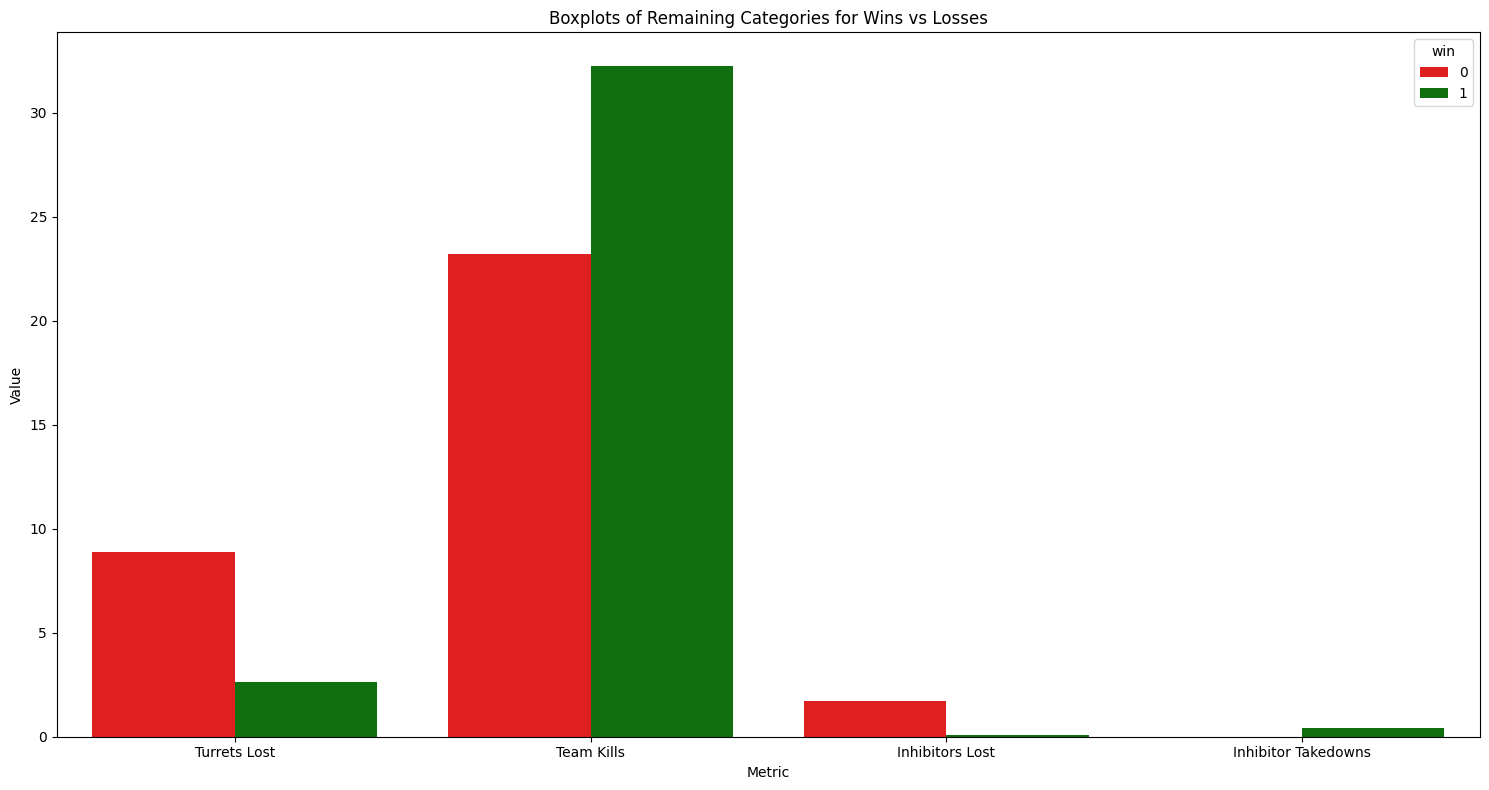

In [140]:
# Create a new DataFrame for the remaining categories
remaining_categories_df = pd.DataFrame({
    'Turrets Lost': towersLost,
    'Team Kills': teamKills,
    'Inhibitors Lost': inhibitorsLost,
    'Inhibitor Takedowns': inhibitorTakedowns
})

# Reset index to make 'win' a column for plotting purposes
remaining_categories_df.reset_index(inplace=True)

# Set the figure size for the box plots
plt.figure(figsize=(15, 8))

# Melt the DataFrame to long format for seaborn
remaining_categories_melted = remaining_categories_df.melt(id_vars='win', var_name='Metric', value_name='Value')

# Create a custom color palette: win = green, loss = red
custom_palette = {True: 'green', False: 'red'}

# Create the boxplots for the categories
sns.barplot(x='Metric', y='Value', hue='win', data=remaining_categories_melted, palette=custom_palette, ci="sd")



# Set plot title and labels
plt.title('Boxplots of Remaining Categories for Wins vs Losses')
plt.xlabel('Metric')
plt.ylabel('Value')

# Show the plot
plt.tight_layout()
plt.show()

### ML Improvement Plan

In [212]:
df_post = df_pre.copy()

extra_num = 1

# 300 extra damage to turrets
df_post['turretsLost'] = df_post['turretsLost'] - extra_num

X = df_post.drop('win',axis=1)
y = df_post['win']

original_win_rate = y.mean()

# get predictions
prediction = model.predict(X)

adjusted_val_df = pd.DataFrame({

    'prediction' : prediction,
    'Original' : y

})

adjusted_win_rate = prediction.mean()

# Winrate Change
print(f"Original Win Rate: {original_win_rate * 100:.2f}%")
print(f"Adjusted Win Rate (with -{extra_num} turrets lost per game): {adjusted_win_rate * 100:.2f}%")

Original Win Rate: 53.33%
Adjusted Win Rate (with -1 turrets lost per game): 56.67%
